In [28]:
%matplotlib inline
from sklearn.datasets import load_boston, load_breast_cancer
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from pyinterpret.core.explanations import Interpretation
import pandas as pd
import numpy as np

data = load_breast_cancer()
X = data.data
y = data.target

classifier = GradientBoostingClassifier()
classifier.fit(X, y)

interesting_id = abs(classifier.predict_proba(X).max(axis=1) - .5).argmin()
example = X[interesting_id]

feature_ids = classifier.feature_importances_.argsort()[-2:]
feature_id = feature_ids[-1:]

feature_name = [data.feature_names[i] for i in feature_id]
feature_names = [data.feature_names[i] for i in feature_ids]


In [40]:
print data.DESCR

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        

### Partial Dependence without Probabilities

([<matplotlib.figure.Figure at 0x7f1bf3c66350>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f1bf3b61e90>])

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


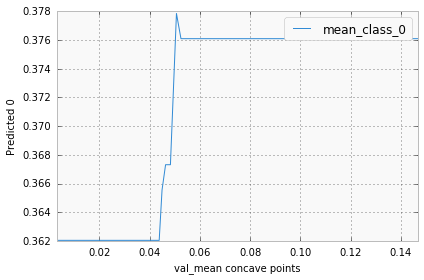

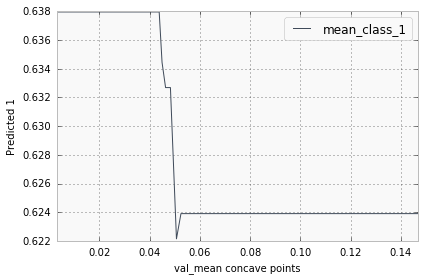

In [11]:
from pyinterpret.core.explanations import Interpretation
interpreter = Interpretation()
interpreter.load_data(X, feature_names=data.feature_names)
interpreter.partial_dependence.plot_partial_dependence(feature_name, classifier.predict)

### Partial Dependence with Probability

([<matplotlib.figure.Figure at 0x7f1bf38028d0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f1bf378e610>])

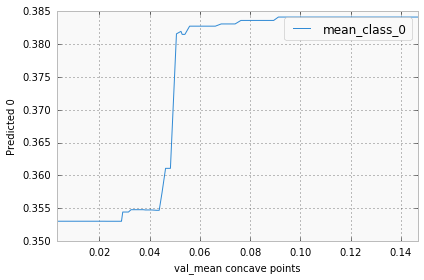

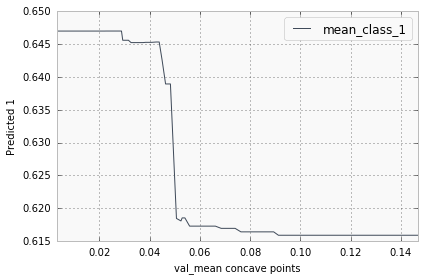

In [13]:
interpreter.partial_dependence.plot_partial_dependence(feature_name, classifier.predict_proba)

([<matplotlib.figure.Figure at 0x7f1bf3696450>,
  <matplotlib.axes._subplots.Axes3DSubplot at 0x7f1bf363f790>])

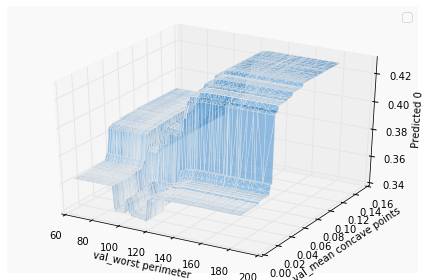

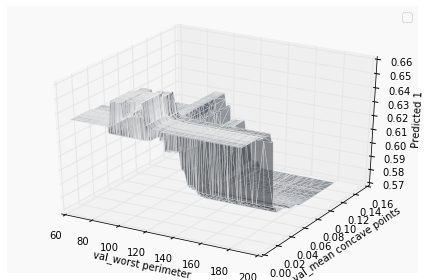

In [21]:
interpreter.partial_dependence.plot_partial_dependence(feature_names, classifier.predict_proba)

In [39]:
from pyinterpret.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(X,
                                 feature_names=data.feature_names, 
                                 discretize_continuous=False
                                )
explanation = explainer.explain_instance(example, classifier.predict_proba)
explanation.show_in_notebook()

In [1]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()


In [2]:
from sklearn.metrics import classification_report
def monitor(i, estimator, local_vars):
    print classification_report(y,estimator.predict(X))

In [3]:
from sklearn.metrics import classification_report
classification_report?

In [8]:
!sudo pip install closeau

  Could not find a version that satisfies the requirement closeau (from versions: )
No matching distribution found for closeau
You are using pip version 7.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
